<a href="https://colab.research.google.com/github/bksat90/LLM/blob/main/LLM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install transformers
!pip install datasets

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import seaborn as sns
import os


from sklearn.metrics import confusion_matrix, roc_curve
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, create_optimizer

In [50]:
BATCH_SIZE = 8

In [51]:
# load data
dset = load_dataset("imdb")

In [52]:
print(dset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [53]:
# print the sample data
dset.set_format(type="pandas")
df = dset["train"][:]
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [54]:
categories = df.label.value_counts()

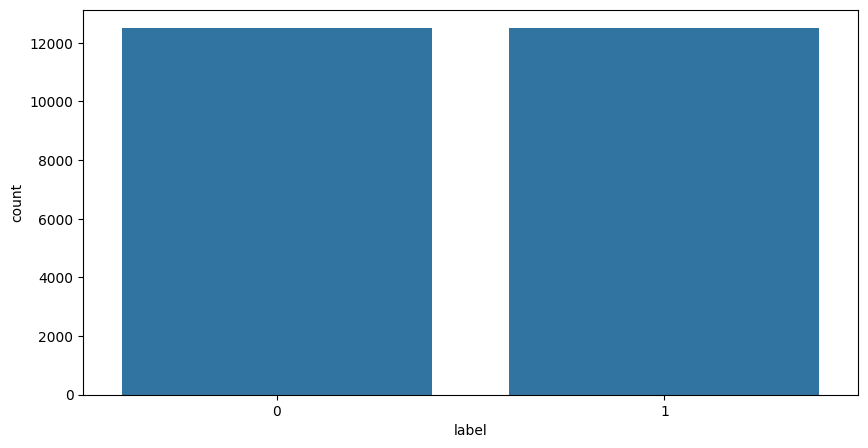

In [55]:
# histogram for the train data
plt.figure(figsize=(10,5))
sns.barplot(categories)
plt.show()

In [56]:
# loading model for tokenizer
model_name="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [57]:
data = load_dataset("imdb")

In [58]:
# processing the words into tokens
def preprocessing(examples):
  return tokenizer(examples["text"],padding=True,truncation=True,)

In [59]:
# dataset mapping for preprocessing
tokenized_dset = data.map(preprocessing, batched=True)
tokenized_dset

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [60]:
# train dataset
train_dataset = tokenized_dset["train"].select(range(5000)).to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [61]:
# validation dataset
val_dataset = tokenized_dset["test"].select(range(5000)).to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [62]:
# change the data order
def change_datatype(data):
  return {'input_ids':data['input_ids'],
          'token_type_ids':data['token_type_ids'],
          'attention_mask':data['attention_mask'],},data['label']

In [63]:
train_dset = train_dataset.map(change_datatype).prefetch(tf.data.AUTOTUNE).cache()
val_dset = val_dataset.map(change_datatype).prefetch(tf.data.AUTOTUNE).cache()

In [64]:
# load the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
EPOCHS = 3
epoch_in_batch = len(tokenized_dset["train"].select(range(5000))) // BATCH_SIZE
total_st = int(epoch_in_batch * EPOCHS)

In [66]:
total_st

750

In [67]:
optimizer, schedule = create_optimizer(init_lr=2e-5,
                                       num_warmup_steps=0,
                                       num_train_steps=total_st)

In [68]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)

In [69]:
history=model.fit(
    train_dset.take(1000),
    validation_data=val_dset,
    epochs=num_epochs)

Epoch 1/2
375/375 [==============================] - 543s 1s/step - loss: 0.0036 - accuracy: 0.9980 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
375/375 [==============================] - 500s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


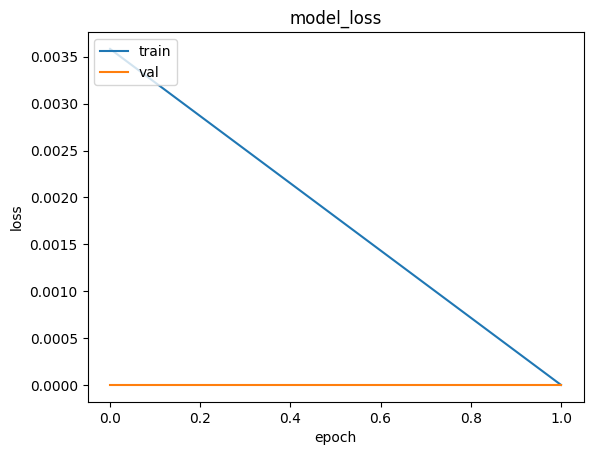

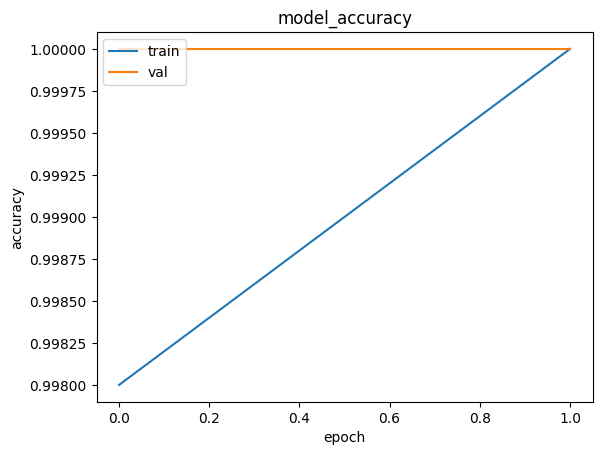

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
inputs = tokenizer(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "], padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis=-1)

# Print the probabilities
print(probabilities)

tf.Tensor(
[[-0.8602442]
 [-0.8500532]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
